*Vision Transformers (ViT), since their introduction by [Dosovitskiy et. al](https://arxiv.org/abs/2010.11929) in 2020, have dominated the field of Computer Vision, obtaining state-of-the-art performance in image classification first, and later on in other tasks as well*. This is a sentence from a [medium post](https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c) that this tutorial is based on. You can also read [this blog](https://www.pinecone.io/learn/series/image-search/vision-transformers/) for further understanding.

<br>

-  Transformer models are firstly intorduced in Natural Language Processing (NLP).
-  They are also used in Image Processing tasks (Vision Transformers)
- They usually require a lot of data for training.
- In large data regimes, they are very effective and state-of-the-art models for solving PDEs!

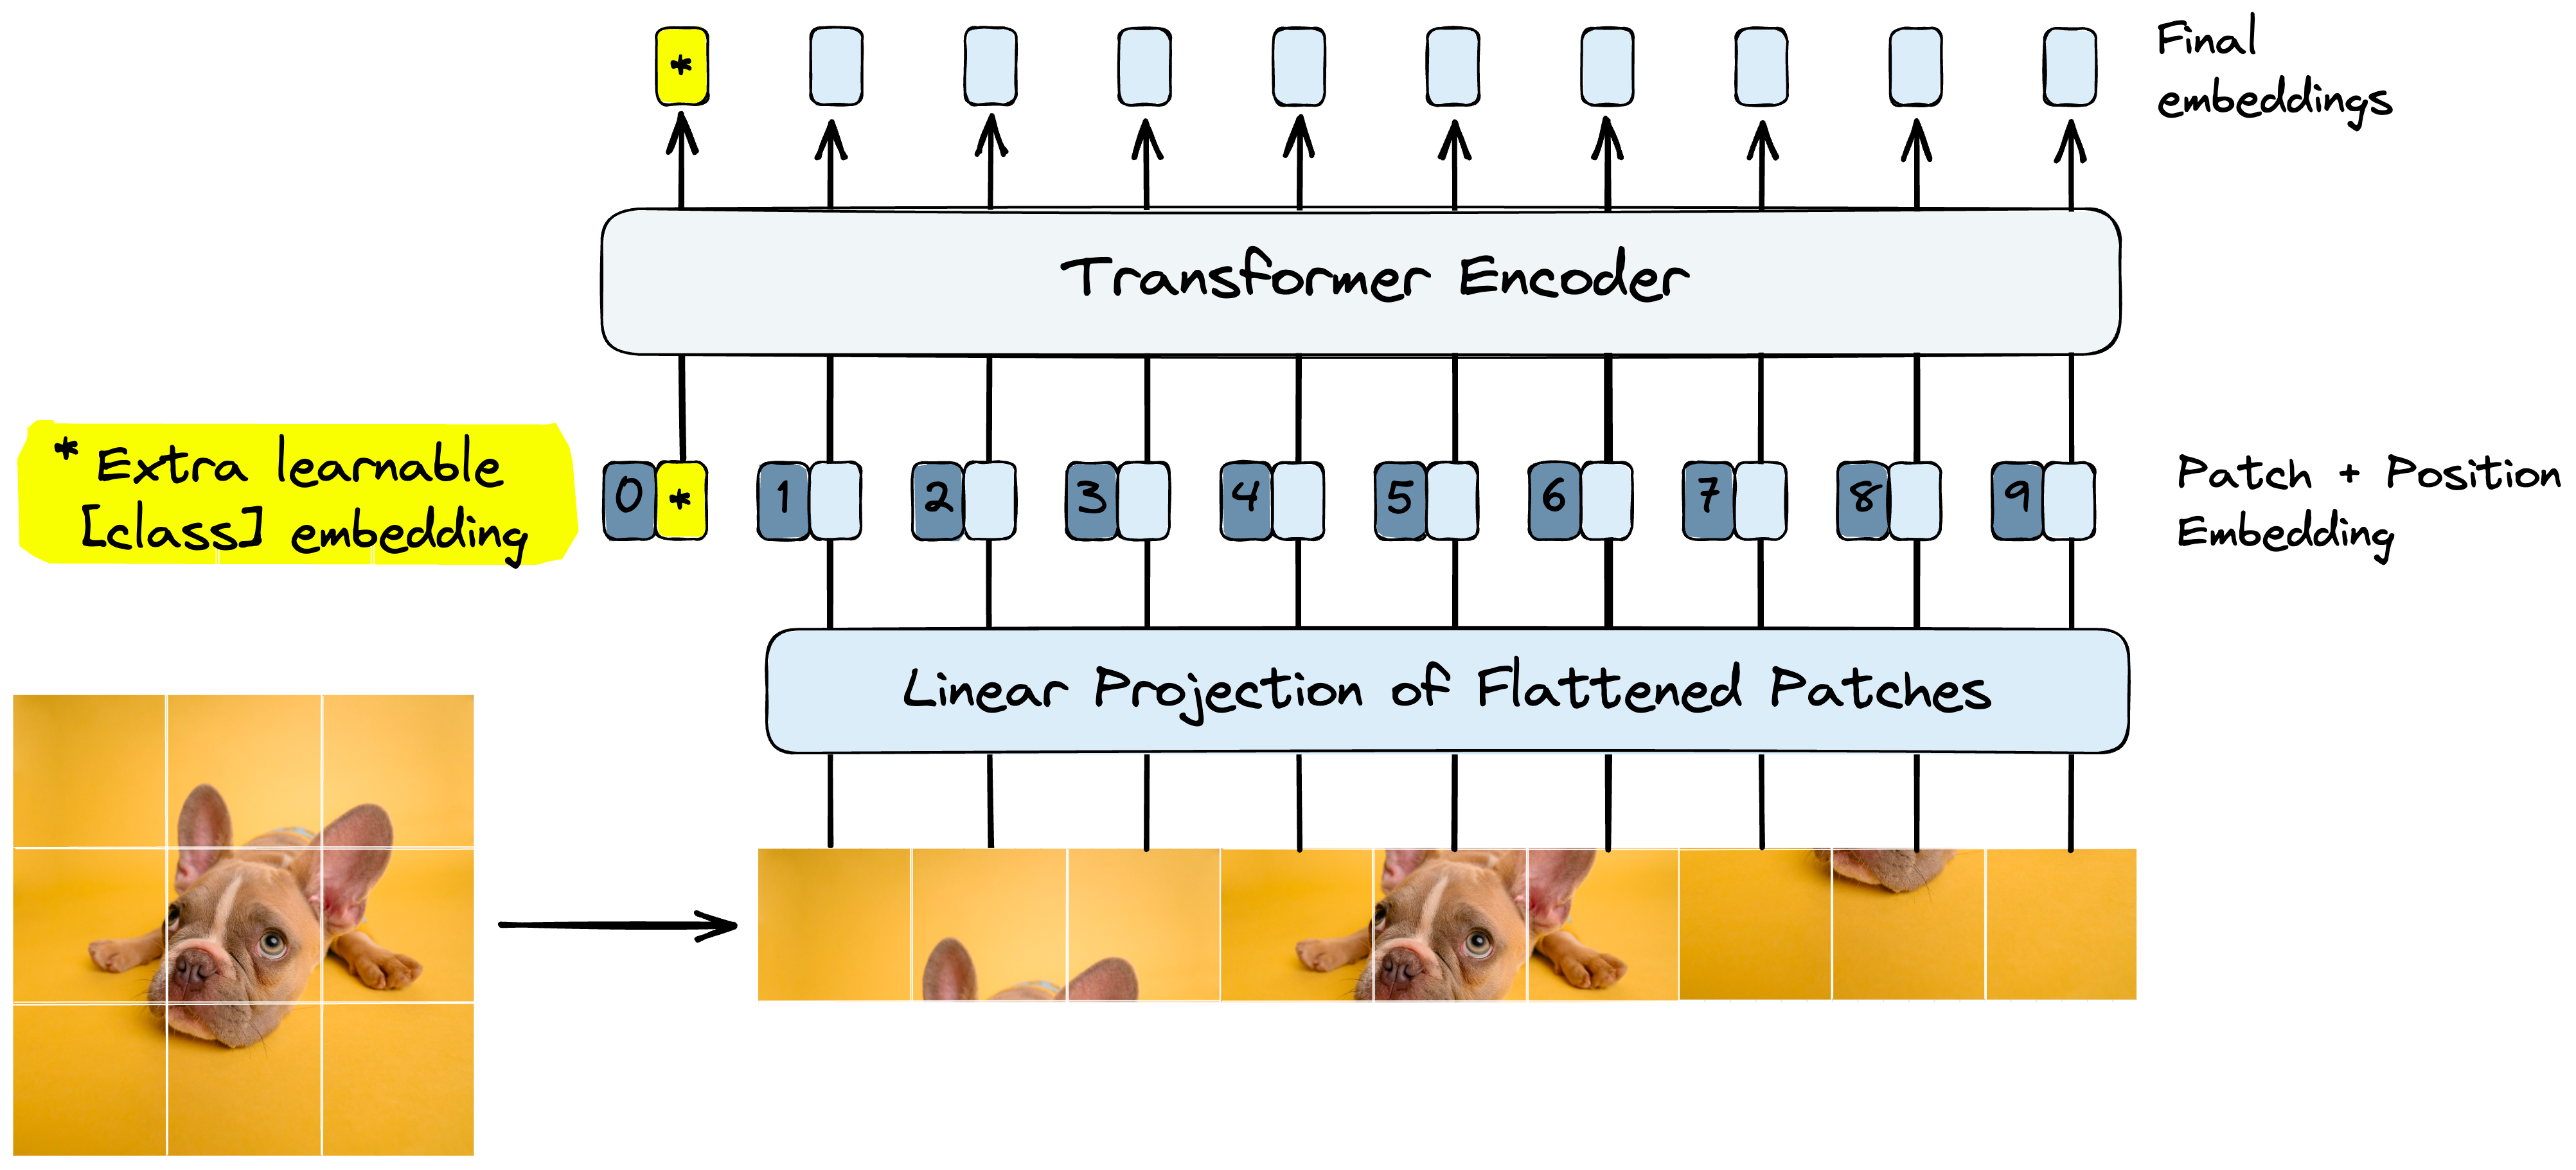

## Image as a sequence


The transformer models were developed with **sequence data in mind**, such as English sentences. However, an image is not a sequence. To apply Transformer architecture, we need to transform input image to a sequence. This process is called **patchification**.

After the input image is patchified, we add so called positional embedings. **Positional embedding** allows the model to understand where each patch would be placed in the original image. We learn those embeddigns from the data, in a form of a simple, learnable matrix.

## Self-attention

The core of a transformer model is self-attention mechanism.

*Self-attention operates by transforming the input sequence into three vectors: query, key, and value. These vectors are obtained through linear transformations of the input. The attention mechanism calculates a weighted sum of the values based on the similarity between the query and key vectors. The resulting weighted sum, along with the original input, is then passed through a feed-forward neural network to produce the final output. This process allows the model to focus on relevant information and capture long-range dependencies* (see [reference](https://h2o.ai/wiki/self-attention/)).

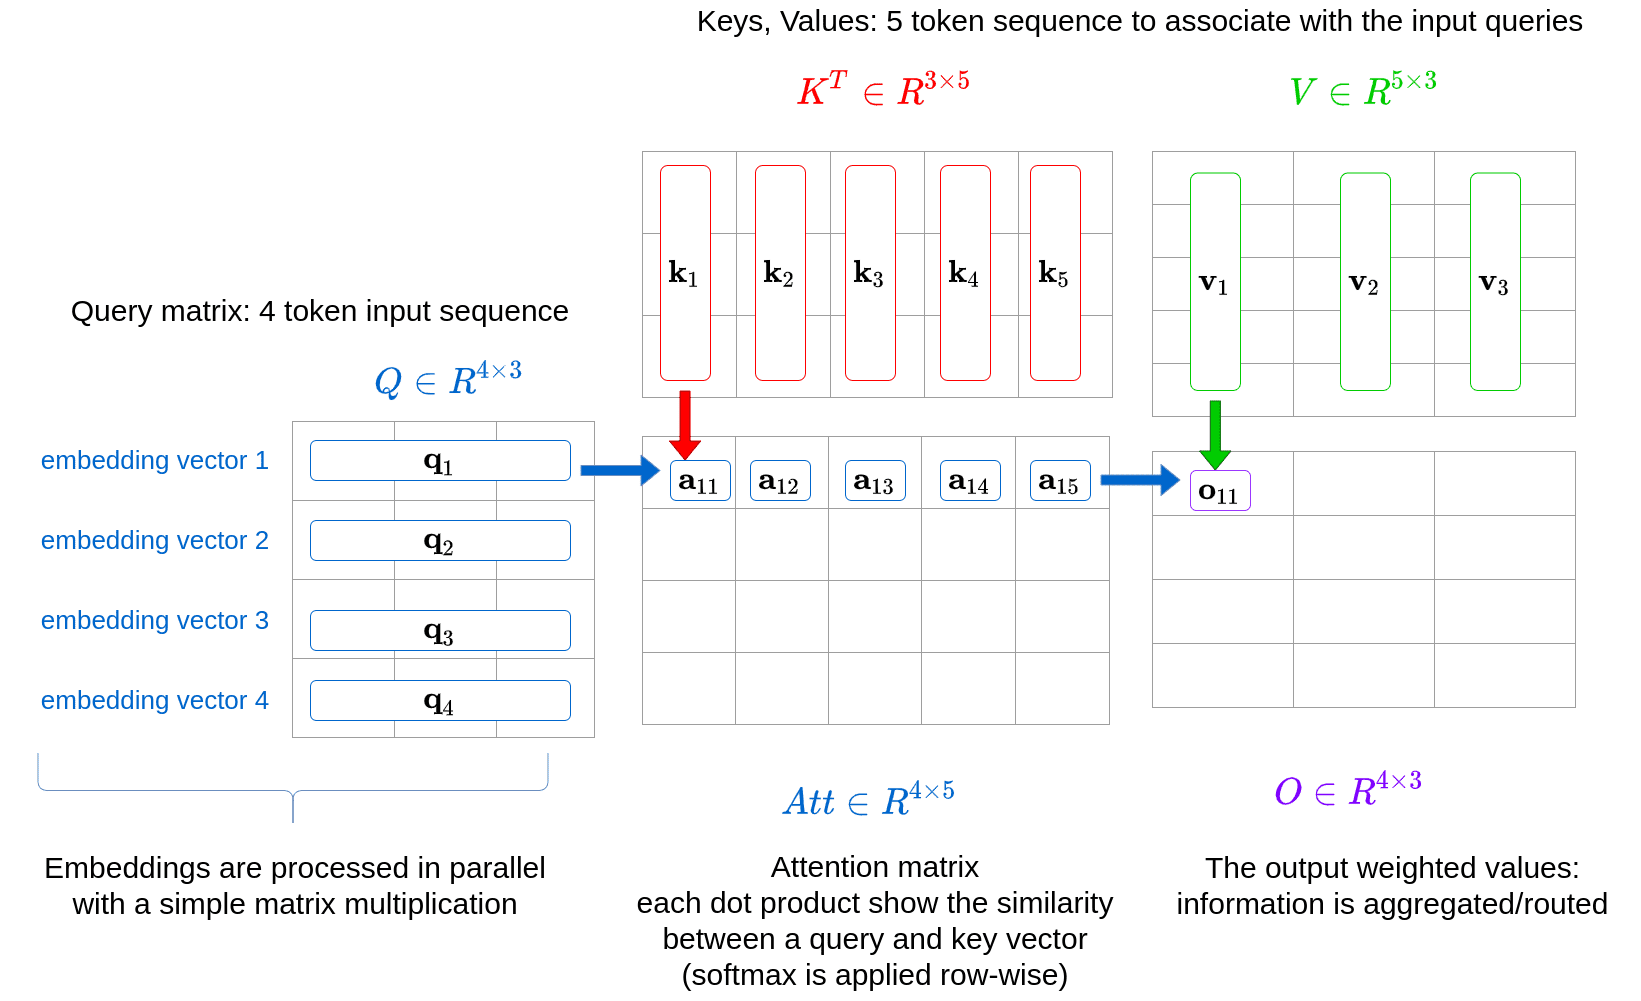

(Image is taken from [this blog](https://theaisummer.com/self-attention/))

## Multi-head self-attention

Multi-headed self-attention performs the same procedure as simple self-attenttion in parallel across multiple “heads”. Each head has separate, learnable matrices for producing key, query, and value vectors. To get the final output of the multi-headed self-attention layer, we can aggregate the outputs of each self-attention head (e.g., via adding, concatenating, etc.). (See [reference blog](https://medium.com/@akash.kesrwani99/multi-head-self-attention-short-understanding-e90a34866730)).

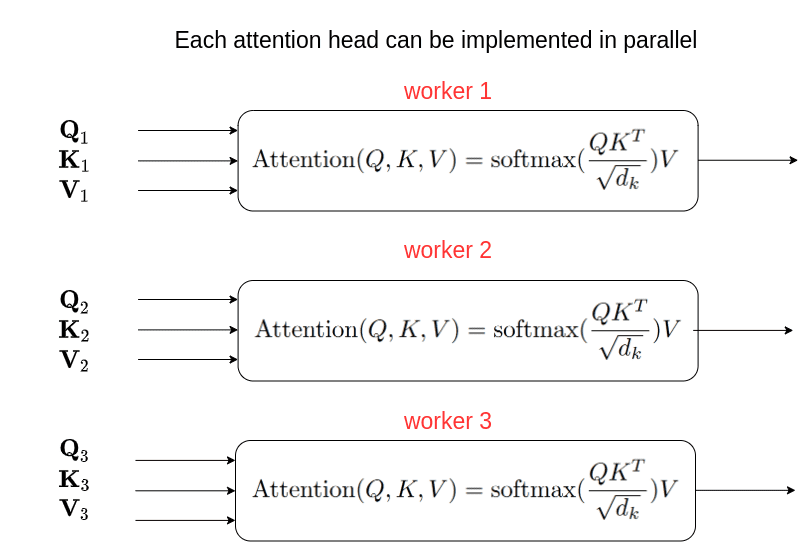

(Image is taken from [this blog](https://theaisummer.com/self-attention/))

## Transformer Block

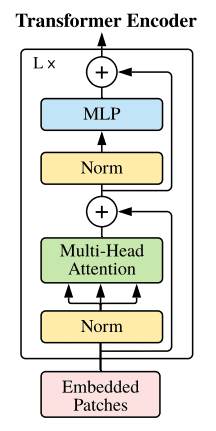



### Vision Transformer is made of 4 different "blocks":

1. Patchify your input image
2. Add positional embedding
3. Apply Transformer Core (N Transformer Blocks)
4. Depatchify your output sequence to get a prediction

<br>
<br>
<br>
<br>


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch
import einops

from einops import rearrange
from einops.layers.torch import Rearrange

import random
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from torch.optim import AdamW

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
# Appplies following operations:
# 1. LayerNorm
# 2. nn.Linear (dim --> hidden_dim)
# 3. GELU
# 4. Dropout
# 5. nn.Linear (hidden_dim --> dim)
# 6. Dropout

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# Takes a sequence of embedding of dimension dim
# 1. Applies LayerNorm
# 2. Applies linear layer dim -> 3x inner_dim
#                                NOTE: inner_dim = dim_head x heads
# 3. Applies attention
# 4. Projects inner -> dim

class AttentionBlock(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


In [ ]:
# Takes sequence of embeddings of dimension dim
# 1. Applies depth times:
#    a) Attention block: dim->dim (in the laast dimension)
#    b) MLP block:       dim->dim (in the laast dimension)
# 2. Applies LayerNorm

class TransformerBlock(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                AttentionBlock(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

def pair(t):
    return t if isinstance(t, tuple) else (t, t)


In [ ]:
# Takes an image of size (n, c, h, w)
# Finds patch sizes (p_h, p_w) & number of patches (n_h, n_w)
# NOTE: It must hold that h%p_h == 0

# 1. Applies to_patch_embedding :
#     a. (n, c, p_h*p1, p_w*p2) -> (n, n_h*n_w, p_h*p_w*c)
#     b. LayerNorm
#     c. Linear embedding p_h*p_w*c -> dim
#     d. LayerNorm
# 2. Add positional embedding
# 3. Apply Transformer Block
# 4. Depatchify

class ViT(nn.Module):
    def __init__(self,
                image_size,
                patch_size,
                dim,
                depth,
                heads,
                mlp_dim = 256,
                channels = 1,
                dim_head = 32,
                emb_dropout = 0.,):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.patch_to_image = nn.Sequential(
            nn.Linear(dim, patch_dim),
            nn.LayerNorm(patch_dim),
            Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1 = patch_height, p2 = patch_width, h = image_height // patch_height)
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = TransformerBlock(dim, depth, heads, dim_head, mlp_dim)

        self.conv_last = torch.nn.Conv2d(in_channels = channels,
                                          out_channels= channels,
                                          kernel_size = 3,
                                          padding     = 1)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        _, n, _ = x.shape
        x += self.pos_embedding[:, :n]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.patch_to_image(x)
        x = self.conv_last(x)
        return x


    def print_size(self):
        nparams = 0
        nbytes = 0

        for param in self.parameters():
            nparams += param.numel()
            nbytes += param.data.element_size() * param.numel()

        print(f'Total number of model parameters: {nparams})')

        return nparams


In [ ]:
########################
# Dataloader definition:
########################

class AllenCahnDataset(Dataset):
    def __init__(self, which="train", training_samples = 256):

        assert training_samples<=256

        #Default file:
        self.file_data = "AllenCahn_NEW.h5"
        self.reader = h5py.File(self.file_data, 'r')

        #Load normaliation constants:
        self.min_data = self.reader['min_u0'][()]
        self.max_data = self.reader['max_u0'][()]
        self.min_model = self.reader['min_u'][()]
        self.max_model = self.reader['max_u'][()]

        if which == "train":
            self.length = training_samples
            self.start = 0
        elif which == "val":
            self.length = 128
            self.start = 256
        elif which == "test":
            self.length = 128
            self.start = 256+128

        self.reader = h5py.File(self.file_data, 'r')

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["input"][:]).type(torch.float32).reshape(1, 64, 64)
        labels = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["output"][:]).type(torch.float32).reshape(1, 64, 64)

        inputs = (inputs - self.min_data)/(self.max_data - self.min_data)
        labels = (labels - self.min_model)/(self.max_model - self.min_model)

        return inputs, labels


In [ ]:
training_samples = 256
batch_size = 16

train_dataset = AllenCahnDataset(which="train", training_samples = training_samples)
val_dataset = AllenCahnDataset(which="val")

train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)


Text(0.5, 1.0, 'Output')

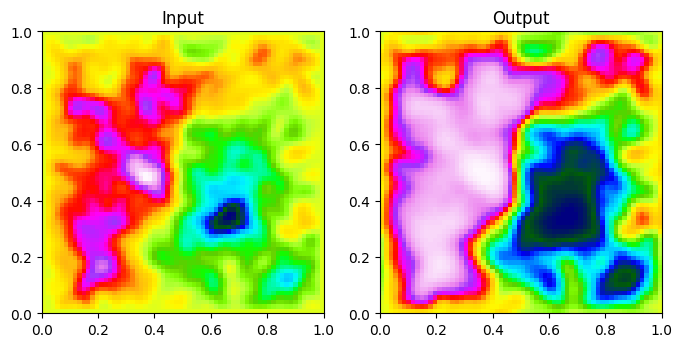

In [ ]:
input, output = next(iter(train_loader))
input = input[0,0].numpy()
output = output[0,0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[1].set_title("Output")


In [ ]:
image_size = 64
patch_size = 16
dim = 128
depth = 4
heads = 4
dim_head = 32
emb_dropout = 0.0

model = ViT(image_size = image_size,
            patch_size = patch_size,
            dim = dim,
            depth = depth,
            heads = heads,
            mlp_dim = 256,
            channels = 1,
            dim_head = dim_head,
            emb_dropout = emb_dropout)

model.print_size()



Total number of model parameters: 597898)


597898

In [ ]:
X = torch.rand(16,1,64,64)
Y = model(X)

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 200, eta_min=10**-6)
l = nn.L1Loss()

epoch = 200

freq_print = 1
for epoch in range(epoch):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output_pred_batch = model(input_batch)
        loss_f = l(output_pred_batch, output_batch) / l(output_batch, torch.zeros_like(output_batch))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l1 = 0.0
        for step, (input_batch, output_batch) in enumerate(val_loader):
            output_pred_batch = model(input_batch)
            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
            test_relative_l1 += loss_f.item()
        test_relative_l1 /= len(val_loader)

    if epoch % freq_print == 0: print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_lr())



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1437: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


## Epoch: 0  ## Train Loss: 1.1091251373291016 ## Rel L1 Test Norm: 101.50207138061523 LR:  [0.0009999383779245895]
## Epoch: 1  ## Train Loss: 0.9692222774028778 ## Rel L1 Test Norm: 93.56251049041748 LR:  [0.0009997535269026829]
## Epoch: 2  ## Train Loss: 0.8959097862243652 ## Rel L1 Test Norm: 85.84438228607178 LR:  [0.000999445492543504]
## Epoch: 3  ## Train Loss: 0.8112742230296135 ## Rel L1 Test Norm: 76.86874389648438 LR:  [0.0009990143508499217]
## Epoch: 4  ## Train Loss: 0.7222574986517429 ## Rel L1 Test Norm: 68.11128234863281 LR:  [0.0009984602081996976]
## Epoch: 5  ## Train Loss: 0.6328232511878014 ## Rel L1 Test Norm: 60.26636552810669 LR:  [0.0009977832013192385]
## Epoch: 6  ## Train Loss: 0.5526678934693336 ## Rel L1 Test Norm: 53.69521141052246 LR:  [0.0009969834972498623]
## Epoch: 7  ## Train Loss: 0.48236801847815514 ## Rel L1 Test Norm: 46.7771201133728 LR:  [0.0009960612933065818]
## Epoch: 8  ## Train Loss: 0.41543749906122684 ## Rel L1 Test Norm: 41.13381099

## Plot

Text(0.5, 1.0, 'Prediction')

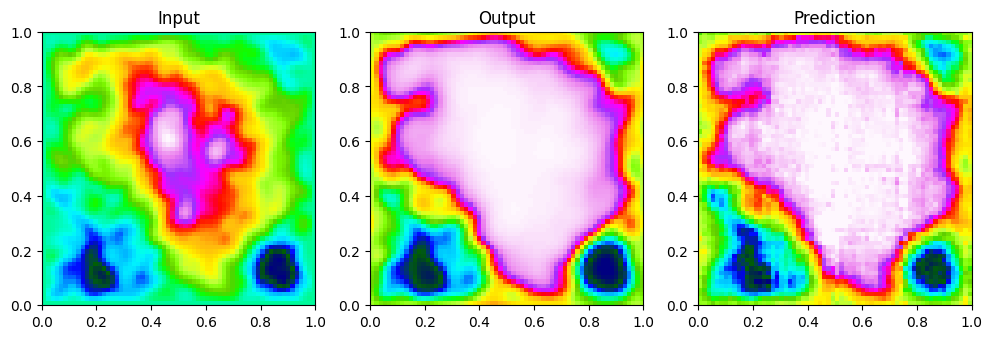

In [ ]:
input, output = next(iter(val_loader))
pred = model(input)
input = input[0,0].numpy()
output = output[0,0].numpy()
pred = pred[0,0].detach().numpy()

vmin = np.min(output)
vmax = np.max(output)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input, cmap = "gist_ncar", extent=(0,1,0,1),)
axes[0].set_title("Input")
axes[1].imshow(output, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[1].set_title("Output")
axes[2].imshow(pred, cmap = "gist_ncar", extent=(0,1,0,1), vmin = vmin, vmax= vmax)
axes[2].set_title("Prediction")


- There are patchification artifact present in the prediction
- There are more complex and more effective ways to patchify and depatchify images, so that the artifacts are avoided!
- However, the prediction is relatively solid.
- **Nowadays, advanced, multi-scale transformers for image processing tasks are much more in use than vanilla ViT.**
